In [1]:
import sys

sys.path.append("../")

import pennylane as qml
import pennylane.numpy as np
from main import *

np.random.seed(0)  # For reproducibility

In this notebook we present the syntaxis to create and evaluate quantum states and operators in first quantization in a qubit-based quantum computer.

In the first place let us define the number of qubits and the device to perform the simulations.

In [2]:
import qiskit
import qiskit.providers.aer.noise as noise

# create a bit flip error with probability p = 0.01
p = 0.01
my_bitflip = noise.pauli_error([('X', p), ('I', 1 - p)])

# create an empty noise model
my_noise_model = noise.NoiseModel()

# attach the error to the hadamard gate 'h' 
my_noise_model.add_quantum_error(my_bitflip, ['h'], [0]) 

In [3]:
num_wires = 3
dev1 = qml.device( 'lightning.qubit', wires=2*num_wires ) 
dev2 = qml.device( 'qiskit.aer', wires=2*num_wires, noise_model = my_noise_model ) 
# dev3 = qml.device( 'qiskit.ibmq', wires=2*num_wires, backend='ibmq_qasm_simulator' ) 
# dev4 = qml.device( 'qiskit.ibmq', wires=2*num_wires, backend='ibm_brisbane' ) 

Second, we create discrete versions of the position operator $X$ and the momentum operator $P$ between $x_{min}=-5$ and $x_{max}=5$ with the function ```X_and_P_ops``` 

In [4]:
X, P = X_and_P_ops(range(num_wires), x_min=-5, x_max=5)
X, P

(<Hamiltonian: terms=1, wires=[0, 1, 2]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2]>)

We now will evaluate the expected value of those operators in a random quantum state $|\psi\rangle$.

(<Figure size 400x400 with 1 Axes>, <Axes: >)

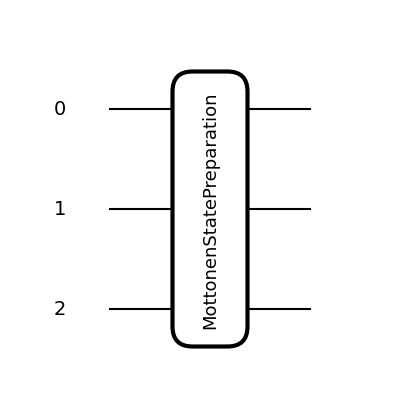

In [5]:
def psi(params):
    qml.MottonenStatePreparation(params, range(num_wires))


params = np.random.randn(2**num_wires) + 1j * np.random.randn(2**num_wires)
params = params / np.linalg.norm(params)

qml.draw_mpl(psi)(params)

We can evaluate the expecting value of $X$ or $P$ over $|\psi\rangle$ creating the corresponding __quantum tape__ with the function ```tapes_XP```.

In [6]:
tape_X = tapes_XP(params, psi, X)
print(tape_X[0].draw())

0: ─╭MottonenStatePreparation(M0)─┤ ╭Probs
1: ─├MottonenStatePreparation(M0)─┤ ├Probs
2: ─╰MottonenStatePreparation(M0)─┤ ╰Probs
M0 = 
[ 0.41768427-0.02443969j  0.0947474 +0.09721964j  0.23174112+0.03410598j
  0.53058848+0.34433625j  0.44219187+0.18019504j -0.2313954 +0.02880966j
  0.2249576 +0.10509591j -0.03583767+0.07900589j]


The expected value is given by the function ```exp_val_XP```.

In [7]:
exp_val_XP(circuit_tapes=tape_X, device=dev1), exp_val_XP(circuit_tapes=tape_X, device=dev2)

(-0.8072673075874343, -0.7672991071428571)

In [8]:
# exp_val_XP(circuit_tapes=tape_X, device=dev3)

In [9]:
# exp_val_XP(circuit_tapes=tape_X, device=dev4) 

We can also directly give the arguments of ```tapes_XP``` to ```exp_val_XP``` and the device

In [10]:
exp_val_XP(params, psi, X, dev1), exp_val_XP(params, psi, X, dev2)

(-0.8072673075874343, -0.7728794642857144)

For the evaluation of $P$, the tape includes the Fourier Transfom to change the basis from the eigenbasis of $X$ to the eigenbasis of $P$.

In [11]:
tape_P = tapes_XP(params, psi, P)
print(tape_P[0].draw())

0: ─╭MottonenStatePreparation(M0)──H─╭●──╭●────────────┤ ╭Probs
1: ─├MottonenStatePreparation(M0)────╰Rϕ─│────H─╭●─────┤ ├Probs
2: ─╰MottonenStatePreparation(M0)────────╰Rϕ────╰Rϕ──H─┤ ╰Probs
M0 = 
[ 0.41768427-0.02443969j  0.0947474 +0.09721964j  0.23174112+0.03410598j
  0.53058848+0.34433625j  0.44219187+0.18019504j -0.2313954 +0.02880966j
  0.2249576 +0.10509591j -0.03583767+0.07900589j]


In [12]:
exp_val_XP(circuit_tapes=tape_P, device=dev1), exp_val_XP(circuit_tapes=tape_P, device=dev2)

(-0.3321309682481336, -0.336095190625744)

Setting the input ```semiclassical=True``` of ```X_and_P_ops```, the evaluation of $P$ is performed with a semiclassical implementation of the Fourier transform. This replaces the controlled operations with mid-circuit measurements and classical controls, thus reducing the depth of the quantum circuit.

In [13]:
X, P = X_and_P_ops(range(num_wires), -5, 5, semiclassical=True)
tape_P = tapes_XP(params, psi, P)
print(tape_P[0].draw())

0: ─╭MottonenStatePreparation(M0)──H──┤↗├─────────────────────┤ ╭Probs
1: ─├MottonenStatePreparation(M0)──────║───Rϕ──H───┤↗├────────┤ ├Probs
2: ─╰MottonenStatePreparation(M0)──────║───║───Rϕ───║───Rϕ──H─┤ ╰Probs
                                       ╚═══╩═══╝    ║   ║             
                                                    ╚═══╝             
M0 = 
[ 0.41768427-0.02443969j  0.0947474 +0.09721964j  0.23174112+0.03410598j
  0.53058848+0.34433625j  0.44219187+0.18019504j -0.2313954 +0.02880966j
  0.2249576 +0.10509591j -0.03583767+0.07900589j]


In [14]:
import pennylane as qml
from pennylane.transforms import fold_global, poly_extrapolate

out = qml.transforms.mitigate_with_zne( tape_P[0], 
                                        [1., 2., 3.], 
                                        fold_global, 
                                        poly_extrapolate, 
                                        extrapolate_kwargs={'order': 2})

len( out[0][0].operations ), len( out[0][1].operations ), len( out[0][2].operations ) 

(40, 80, 120)

In [15]:
print(out[0][0].draw())

0: ──RY─╭●─────╭●────────╭●────────────╭●──RZ─╭●─────╭●────────╭●────────────╭●──Rϕ──RX──Rϕ──┤↗├────
1: ──RY─╰X──RY─╰X─╭●─────│──────╭●─────│───RZ─╰X──RZ─╰X─╭●─────│──────╭●─────│────────────────║───Rϕ
2: ──RY───────────╰X──RY─╰X──RY─╰X──RY─╰X──RZ───────────╰X──RZ─╰X──RZ─╰X──RZ─╰X───────────────║───║─
                                                                                              ╚═══╩═
                                                                                                    

───────────────────────────────────┤ ╭Probs
───Rϕ──RX──Rϕ──┤↗├─────────────────┤ ├Probs
───Rϕ───────────║───Rϕ──Rϕ──RX──Rϕ─┤ ╰Probs
═══╝            ║   ║                      
                ╚═══╝                      


We show a better plot of the Fourier Transform from our implementation of the operation `QFT`, in the standard manner (```semi_classical=False```)

(<Figure size 900x400 with 1 Axes>, <Axes: >)

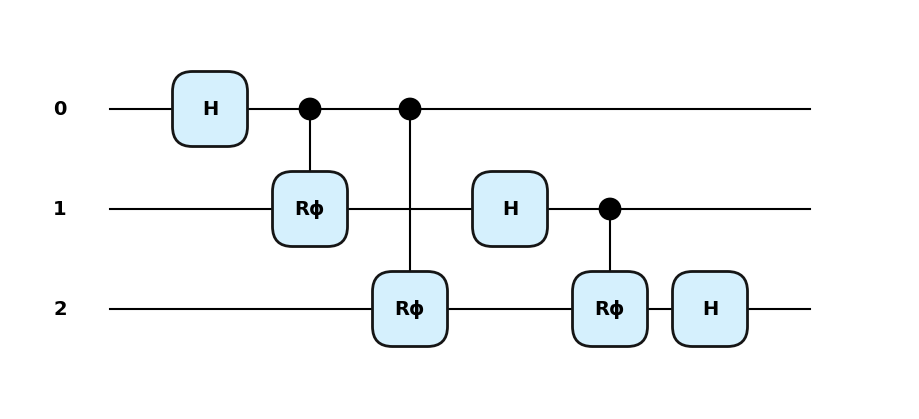

In [16]:
qft = QFT(range(num_wires), semi_classical=False)


def fun():
    qft.decomposition()


qml.draw_mpl(fun, style="pennylane")()

and using the semiclassical variation

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

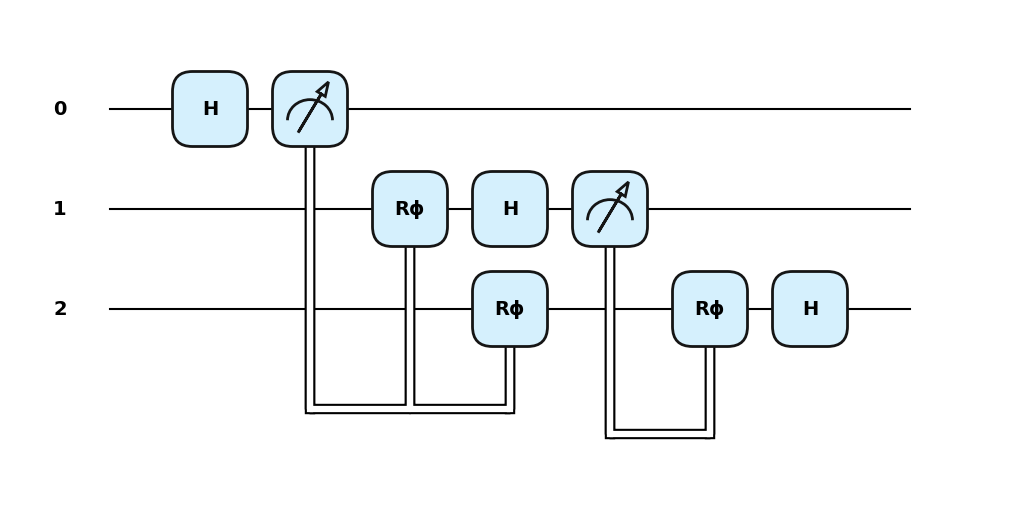

In [17]:
qft = QFT(range(num_wires), semi_classical=True)


def fun():
    qft.decomposition()


qml.draw_mpl(fun, style="pennylane")()

This circuits gives the same expectied value than the standard implementation.

In [18]:
exp_val_XP(circuit_tapes=tape_P, device=dev1 ), exp_val_XP(circuit_tapes=tape_P, device=dev2 )

(-0.3321309682481336, -0.3205252856287047)

In [19]:
# exp_val_XP(circuit_tapes=tape_P, device=dev3 )

In [20]:
# exp_val_XP(circuit_tapes=tape_P, device=dev4 )

We can also evaluate arbitrary quadrature operator $Q=aX+bP$ puting each term of the sum in a ```list```.

In [21]:
a = 1
b = 1

Q = [X.s_prod(a), P.s_prod(b)]
Q

[<Hamiltonian: terms=1, wires=[0, 1, 2]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2]>]

In this case the program perform a simulation for each term in the list.

In [22]:
exp_val_XP(params, psi, Q, dev1)

-1.1393982758355679

Note that function ```exp_val_XP``` is differentiable, resulting convenient for expectation value optimization.

In [23]:
qml.grad(exp_val_XP)(params, psi, Q, dev1)

1.4859744455937676

In [24]:
# qml.grad(exp_val_XP)(params, psi, Q, dev2)

In [25]:
X, P = X_and_P_ops(range(num_wires), -5, 5, semiclassical=True)
tape_P = tapes_XP(params, psi, P)
print(tape_P[0].draw()) 

0: ─╭MottonenStatePreparation(M0)──H──┤↗├─────────────────────┤ ╭Probs
1: ─├MottonenStatePreparation(M0)──────║───Rϕ──H───┤↗├────────┤ ├Probs
2: ─╰MottonenStatePreparation(M0)──────║───║───Rϕ───║───Rϕ──H─┤ ╰Probs
                                       ╚═══╩═══╝    ║   ║             
                                                    ╚═══╝             
M0 = 
[ 0.41768427-0.02443969j  0.0947474 +0.09721964j  0.23174112+0.03410598j
  0.53058848+0.34433625j  0.44219187+0.18019504j -0.2313954 +0.02880966j
  0.2249576 +0.10509591j -0.03583767+0.07900589j]


In [26]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [27]:
tape = qml.transforms.merge_rotations( tape_P[0].expand() )[0][0]
num_qubits = tape.num_wires

In [28]:
tape.operations

[RY(tensor(1.26936233, requires_grad=True), wires=[0]),
 RY(tensor(1.45252455, requires_grad=True), wires=[1]),
 CNOT(wires=[0, 1]),
 RY(tensor(0.53331577, requires_grad=True), wires=[1]),
 CNOT(wires=[0, 1]),
 RY(tensor(1.16014581, requires_grad=True), wires=[2]),
 CNOT(wires=[1, 2]),
 RY(tensor(-0.39212741, requires_grad=True), wires=[2]),
 CNOT(wires=[0, 2]),
 RY(tensor(-0.51026717, requires_grad=True), wires=[2]),
 CNOT(wires=[1, 2]),
 RY(tensor(0.36973048, requires_grad=True), wires=[2]),
 CNOT(wires=[0, 2]),
 RZ(tensor(1.09419383, requires_grad=True), wires=[0]),
 RZ(tensor(-0.2472611, requires_grad=True), wires=[1]),
 CNOT(wires=[0, 1]),
 RZ(tensor(0.23823345, requires_grad=True), wires=[1]),
 CNOT(wires=[0, 1]),
 RZ(tensor(1.36915329, requires_grad=True), wires=[2]),
 CNOT(wires=[1, 2]),
 RZ(tensor(0.37459118, requires_grad=True), wires=[2]),
 CNOT(wires=[0, 2]),
 RZ(tensor(-0.16099404, requires_grad=True), wires=[2]),
 CNOT(wires=[1, 2]),
 RZ(tensor(-0.7260288, requires_grad=T

In [32]:
from main import tape2qiskit

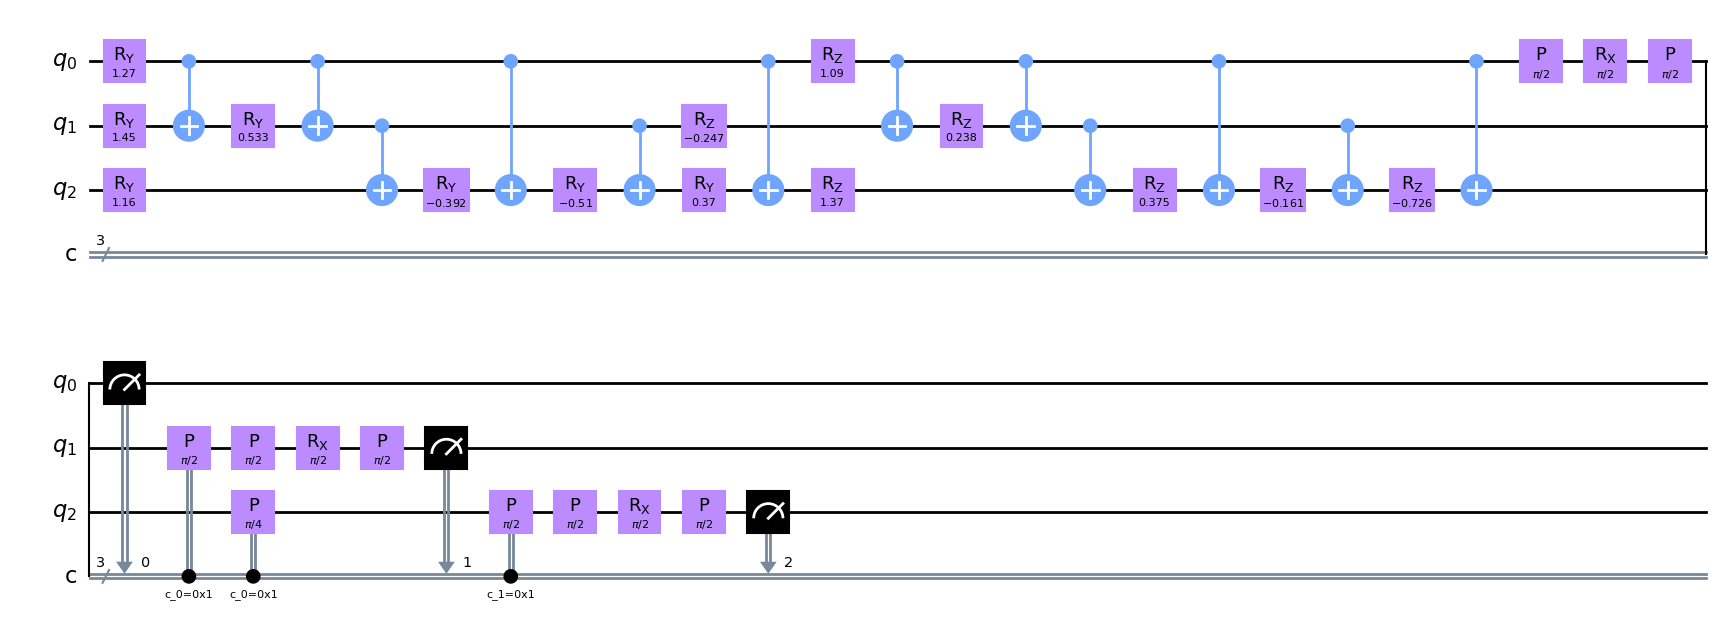

In [33]:
qc = tape2qiskit( tape )
qc.draw('mpl')

In [ ]:
gradient_tapes, fn = qml.gradients.param_shift(tape_P[0])

In [ ]:
print(gradient_tapes[0].expand().draw())

0: ──RY─╭●─────╭●────────╭●────────────╭●──RZ─╭●─────╭●────────╭●────────────╭●──Rϕ──RX──Rϕ──┤↗├────
1: ──RY─╰X──RY─╰X─╭●─────│──────╭●─────│───RZ─╰X──RZ─╰X─╭●─────│──────╭●─────│────────────────║───Rϕ
2: ──RY───────────╰X──RY─╰X──RY─╰X──RY─╰X──RZ───────────╰X──RZ─╰X──RZ─╰X──RZ─╰X───────────────║───║─
                                                                                              ╚═══╩═
                                                                                                    

───────────────────────────────────┤ ╭Probs
───Rϕ──RX──Rϕ──┤↗├─────────────────┤ ├Probs
───Rϕ───────────║───Rϕ──Rϕ──RX──Rϕ─┤ ╰Probs
═══╝            ║   ║                      
                ╚═══╝                      
